
# Tutorial for the routines used in the manuscript

In this tutorial we demonstrate how to use the routines in the file "required_functions.py".
First we need to import some packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from required_functions import logit_model
import numpy.random as rnd
import time


To illustrate how to fit a Logit model, we first generate a data set (from a Logit model) with $n = 1000$ and $p = 700$, this corresponds to $\zeta := p /n = 0.7$.

In [2]:
#sample size
n = 1000
#covariate to sample size  ratio
zeta = 0.7
#number of covariates 
p = int(n * zeta)

We fix the covariance matrix to be a banded matrix with elements
$$
    (\bm{\Sigma}_0)_{j,k}(\epsilon, l) = \delta_{j,k} + \bm{1}[|j-k|<l]\epsilon^{|j-k|} \ .
$$
To this aim we define 

In [3]:
def set_cov(corr, l):
    Sigma =  np.identity(p) 
    for k in range(1,l):
        Sigma = Sigma + (corr**k) * (np.diag(np.ones(p-k), k) + np.diag(np.ones(p-k), -k))
    return Sigma

In our example we wil use $l = 7$ and $\epsilon = 0.5$.

The true associations are sampled as
$$
    \bm{\beta}_0 \sim \mathcal{N}(\bm{0}_p, \bm{I}_p)  \ , 
$$
and are then rescaled to enforce 
$$
    \theta_0 = \|\bm{\Sigma}_0^{1/2}\bm{\beta}_0\|_2  \ ,
$$
for $\theta_0 = 1.0$.


In [4]:

#true signal strength 
theta0 = 1.0
#simulate the model parameters from the prior
beta0 = rnd.normal(size = p)
A0 = set_cov(0.5, 7)
beta0 =  theta0 * beta0 / np.sqrt(beta0 @ A0 @ beta0)


We now define an instance of the "logit_model" class as the model that we are going to fit.
To define the instance, we need to pass the number of parameters $p$ and a set of values for the regularization strength $\alpha$.

In [5]:
alpha_values = np.arange(5.0, 0.05, -0.05)
lg_m = logit_model(p+1, alpha_values)

We now fit the model to the data generate from the Logit model, with the parameters as above.

In [6]:
#generate train data
data_train = lg_m.generate_random_instance(beta0, 0, A0, n)
#fit the model along a regularization path
lg_m.fit(data_train)

Text(0.5, 0, '$\\alpha$')

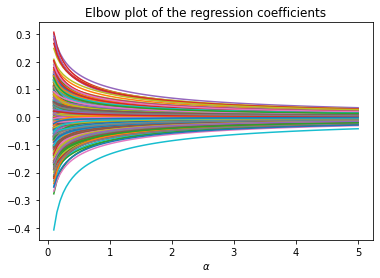

In [7]:
plt.figure()
plt.title('Elbow plot of the regression coefficients')
plt.plot(alpha_values, lg_m.betas)
plt.xlabel(r'$\alpha$')

Let us plot the cross validation loss.

Text(0.5, 0, '$\\alpha$')

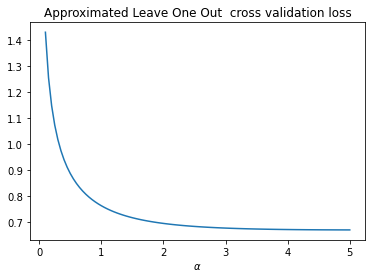

In [8]:
plt.figure()
plt.title('Approximated Leave One Out  cross validation loss')
plt.plot(alpha_values, lg_m.cv_loss)
plt.xlabel(r'$\alpha$')

From now on we consider only $\alpha_{\star}$, defined as the value of $\alpha$ that minimizes the cross validation loss.

The "fit" method, lg_m computes under the hood all the RS order parameters ($w_n, v_n, \tau_n$) along the regularization path.

(0.0, 3.0)

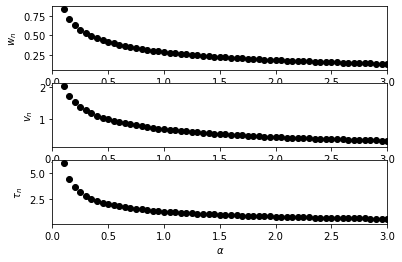

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)

ax1.plot(alpha_values, lg_m.w, 'ko')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = 0.0, right = 3.0)

ax2.plot(alpha_values, lg_m.v, 'ko')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim( left = 0.0, right = 3.0)

ax3.plot(alpha_values, lg_m.tau, 'ko')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = 0.0, right = 3.0)


We can also compare with the solution of the RS equations. This can be solved by importing 'rs_logit' class.

In [11]:
from required_functions import rs_logit
import pandas as pd
metrics = np.empty((len(alpha_values), 7))
#create the rs logit model object 
rs_lg = rs_logit(zeta, theta0, phi0 = 0, m = 5000)
tic = time.time()
for l in range(len(alpha_values)):
    alpha = alpha_values[l]
    #solve rs eqs
    rs_lg.solve(alpha)
    #loo_bs
    cv_bs_loo = rs_lg.cv_bs()
    cv_loss = rs_lg.cv_loss()
    res = np.array([alpha, rs_lg.w, rs_lg.v, rs_lg.tau, cv_bs_loo, cv_loss, rs_lg.corr], float)
    metrics[l,:] = res
df = pd.DataFrame(metrics, columns=['alpha', 'w', 'v', 'tau', 'cv_bs_loo', 'cv_loss', 'corr'])
toc = time.time()
elapsed_time = (toc - tic) /60

(0.0, 3.0)

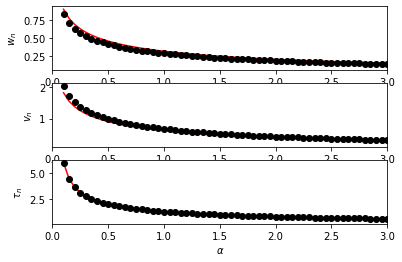

In [12]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(311)
ax2 = fig1.add_subplot(312)
ax3 = fig1.add_subplot(313)

ax1.plot(df['alpha'], df['w'], 'r-')
ax1.plot(alpha_values, lg_m.w, 'ko')
ax1.set_ylabel(r'$w_n$')
ax1.set_xlim(left = 0.0, right = 3.0)

ax2.plot(df['alpha'], df['v'], 'r-')
ax2.plot(alpha_values, lg_m.v, 'ko')
ax2.set_ylabel(r'$v_n$')
ax2.set_xlim( left = 0.0, right = 3.0)

ax3.plot(df['alpha'], df['tau'], 'r-')
ax3.plot(alpha_values, lg_m.tau, 'ko')
ax3.set_ylabel(r'$\tau_n$')
ax3.set_xlabel(r'$\alpha$')
ax3.set_xlim(left = 0.0, right = 3.0)

We now call the method "estimate_theta" to infer the value of the true signal strength.
While calling the "fit" method, lg_m computes also
$$
    \chi_n / w_n := \frac{1}{n}   \mathbf{T}'\big(\mathbf{X}\hat{\bm{\beta}}_n + \tau_n \dot{g}(\mathbf{X}\hat{\bm{\beta}}_n)\big)  / w_n
$$
along the regularization path. 
This quantity can be used to estimate the signal strength $\theta_0$ at $\alpha_{\star}$, by solving 
$$
\chi_n  /w_n  =\mathbb{E}\Big[Z_0\tanh(\theta_n Z_0)\Big]  \ , 
$$
for $\theta_n$, where the expectation is over $Z_0\sim\mathcal{N}(0,1)$.
This is done by Newton method.


In [13]:
tic = time.time()
lg_m.estimate_theta()
toc = time.time()
elapsed_time = (toc-tic) / 60
print('theta_est = '+str(lg_m.theta_est)+' phi_est = ' + str(lg_m.phi_est)+', elapsed_time = '+str(elapsed_time))

theta_est = 0.7856082445343641 phi_est = 0.03762096635572474, elapsed_time = 1.1126200358072916e-05


Once "estimate_theta" is called, we can access the estimator $\hat{\bm{\beta}}_n$ selected by cross validation as 'lg_m.beta_best' and its debiased value $\hat{\bm{\beta}}_n^{(d)}$ 'lg_m.beta_db'.

Text(0.5, 0, '$\\mathbf{\\beta}_0$')

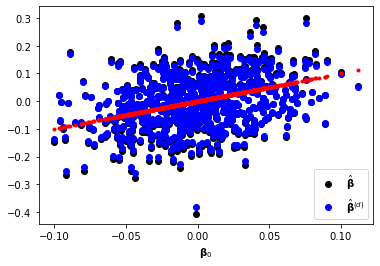

In [14]:
plt.figure()
plt.plot(beta0, lg_m.beta_best, 'ko', label = r'$\hat{\mathbf{\beta}}$')
plt.plot(beta0, lg_m.beta_db, 'bo', label = r'$\hat{\mathbf{\beta}}^{(d)}$')
plt.plot(beta0, beta0, 'r.')
plt.legend()
plt.xlabel(r'$\mathbf{\beta}_0$')



We now compute the variance of each component of $\hat{\bm{\beta}}_n$ as detailed in the manuscript.
In the next script we compute an estimate of $\|\bm{\Sigma}_0^{-1/2}\mathbf{e}_j\|_2^2$ as $1/ \hat{\omega}_j^2$, computed as 
$$
     \hat{\omega}_j^2 =  \Big(\frac{1}{n}\|\mathbf{X}\mathbf{e}_j - \mathbf{X}_{(j)}\hat{\gamma}_j\|_2^2\Big)  / (1-\zeta) \ .
$$

In [16]:
t, x = data_train
omega = np.zeros(p)
for j in range(p):
    Xj = x[:,j] 
    filt_col = (np.arange(0, p+1, 1) != j)
    Z = x[:, filt_col]
    gamma = np.linalg.inv(np.transpose(Z) @ Z) @ (np.transpose(Z) @ Xj)
    omega[j] = np.sqrt( np.mean((Xj - Z @ gamma)**2) / (1- zeta) )

sigma = lg_m.v_db / (omega * np.sqrt(p))

Finally we make a QQ- plot to understand if the component of the de-biased estimator are effectively distributed as a standard gaussian (when rescaled by the component-wise variance).

In [17]:
from scipy.special import erf 

def Q(x):
    return 0.5 + 0.5*erf(x/np.sqrt(2))

Text(0, 0.5, 'theoretical quantiles')

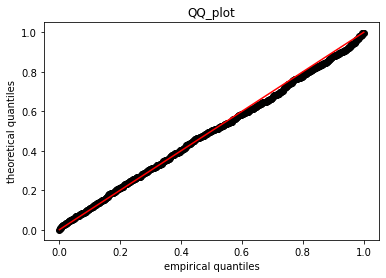

In [18]:
db_residuals = (lg_m.beta_db - beta0) / sigma

ord_res_db = np.sort(db_residuals)
emp_quants = np.arange(1, len(ord_res_db) + 1, 1) / len(ord_res_db)
theo_quants_db = [Q(ord_res_db[j]) for j in range(len(ord_res_db))]

plt.figure()
plt.title('QQ_plot')
# plt.plot(emp_quants, theo_quants, 'b.')
plt.plot(emp_quants, theo_quants_db, 'ko', label = 'de-biased')
plt.plot(emp_quants, emp_quants, 'r-')
plt.xlabel('empirical quantiles')
plt.ylabel('theoretical quantiles')


We can now test for the hypotheses $H_j \ : \ \mathbf{e}_j'\bm{\beta}_0 = 0$ for $j = 1, \dots, p$ (with $p= 700$).
In order to have a reasonable confidence in the conclusion, we need a confidence level of $0.999$ that is, we need a test that might wrongly reject the null hypothesis $1$ out of $1000$ times.


The $\delta\%$ confidence region for the $j$th component is obtained by inverting 
$$
    P\Big[\big|\mathbf{e}_{j}'\hat{\bm{\beta}}_n^{(d)}/\hat{\sigma}_j \big| < t_{c}\Big] = 2 \mathcal{Q}(t_c) - 1= \delta\ , 
$$
where 
$$
    \hat{\sigma}_j := \frac{1}{\sqrt{p}}v_{\star}/\hat{\omega}_j 
$$
for $t_c$.

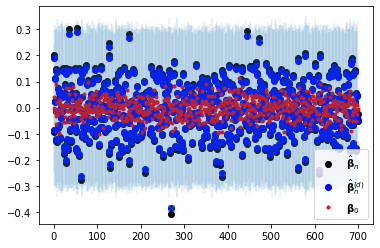

In [30]:
import scipy.stats as sps
dist = sps.norm(loc=0, scale=1)
std_db_res = lg_m.v_db / (omega * np.sqrt(p))
conf_regs = std_db_res * dist.ppf(0.5*(1.0 +0.999)) 
# flag = np.array(np.abs(cox_m.beta_db) >= std_db_res, int)
flag = (np.abs(lg_m.beta_db) > conf_regs)
plt.figure()
plt.plot(lg_m.beta, 'ko', label = r'$\hat{\mathbf{\beta}}_n$')
plt.plot(lg_m.beta_db, 'bo', label = r'$\hat{\mathbf{\beta}}_n^{(d)}$')
plt.plot(beta0, 'r.', label = r'$\mathbf{\beta}_0$')
plt.plot(np.arange(p)[flag], lg_m.beta_db[flag], 'gx')
plt.errorbar(np.arange(p), np.zeros(p), yerr= conf_regs, alpha = 0.1)
plt.legend()
